# Testing assumptions about comment toxicity

### John Burt

[To hide code cells, view this in nbviewer](https://nbviewer.jupyter.org/github/johnmburt/springboard/blob/master/capstone_1/reddit_reply_to_troll_analysis_v9.ipynb) 


### Introduction:

The goal of my first Capstone project is to develop a toxic comment classifier. One of the challenges for this project is that although I have a large set of comments with numerous features, Reddit provides no definitive label of "toxic" vs "non-toxic". As a substitute, I have made a logical assumption that comments that are heavily downvoted are more likely to be toxic. But, how do I test this assupmtion?

One way to verify that comment features indicate toxicity is by examining the text of replies to them. 

Do comments with replies containing "call-out" words and phrases such as "troll" have different feature levels than comments that are not called out? For example, vote score is my primary measure of toxicity. Do comments with troll call-out replies have lower vote scores? If so, then that would provide more evidence that a low vote score is associated with toxicity.

In [17]:
from IPython.display import HTML
# from IPython.display import Image
# Image("eyeexam.jpg")

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

### Methods

The original comment data used in this capstone project was [acquired using PRAW](https://github.com/johnmburt/springboard/blob/master/capstone_1/reddit_collect_comments_v1.ipynb) by sampling comments in posts from 12 subs. 

The comment data used here was further processed from the original data:
- I'm only looking at comments that are replies to other comments.
- Feature data for the comment replied to (i.e., the potential troll comment) was added to each reply comment:
    - replyto_score
    - replyto_pca_score
    - replyto_com_karma
    - replyto_num_replies


* Note: The "reply enhanced" data used here [was generated in a different notebook.](https://github.com/johnmburt/springboard/blob/master/capstone_1/reddit_reply_to_troll_analysis_make_reply_data_v2.ipynb)

In [18]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import pandas as pd
pd.options.display.max_columns = 100

import numpy as np
import datetime
import time
import csv
import glob


# source data folder 
srcdir = './data_labeled/'

reply_df = pd.read_csv(srcdir+'comment_sample_all_plus_replies.csv').drop_duplicates()

# print('\nTotal comment samples read:',reply_df.shape[0])

### Count number of "troll reply" words and plot that against the toxicity features

Here I count occurences of "troll reply" words - words that might be used by other users calling out a troll for a toxic comment. For this analysis, I'll simply count reply comments with words that contain "troll".

Note that I'm processing the data from the perspective of replies to potential trolls. The "replyto_..." columns are the features of the comment replied to.

Each feature tested will belong to the comment replied to (e.g., "replyto_score"), and will be grouped on the basis of whether the reply contains the word "troll"

I will use t-tests to determine whether the "has troll word in reply" vs. "has no troll words" groups have significantly different feature values (2-tailed independent samples t-test, alpha p < .05).


In [19]:
# helper function to do stats comparison and plot bar graph

def troll_reply_test(df, testcol, alpha=0.05, label=None):
    """Test whether dependent variable is different if reply text
        contains 'troll words', and plot means as a bar graph."""
    
    if label is None: label = testcol
        
    istrollreply = df['istrollreply'] == 'yes'
    
    print('\n')
    print('Dependent variable:',testcol)
    print('Mean: NO = %1.3f, YES = %1.3f'%(
          df[testcol][~istrollreply].mean(),
          df[testcol][istrollreply].mean() ))

    # separate data into replies w/ vs without troll reply words
    no_troll = df[testcol][~istrollreply].dropna()
    yes_troll = df[testcol][istrollreply].dropna()
    
    # t-test
    stat, pval = ttest_ind(no_troll,yes_troll)

    print('unpaired t-test results: t = %1.3f, pval = %1.6f %s'%(
        stat, pval, 'significant' if pval<alpha else 'non-significant'))

    # plot bar graph
    f, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(x='istrollreply',y=testcol,data=df);
    plt.title('Reply contains troll reply words vs '+label);
    plt.xlabel('Contains troll reply words')
    plt.ylabel(label)


In [20]:
import seaborn as sns
from scipy.stats import ttest_ind

alpha = .05

# Count occurrences of words associated with accusations of trollery

# Note: you can include multiple words and phrases to this list, but 
#       here, I just use the word troll (w/ a pre-space to eliminate words 
#       that end in 'troll')
trollwords = [' troll']

# create regex expression to search for troll reply words
trolltest = '|'.join(trollwords)

# count replies with at least one of the troll reply words
reply_df['trollcount'] = reply_df.text.str.count(trolltest)

# add boolean column indicating a troll word was in a reply
reply_df['istrollreply'] = np.where((reply_df['trollcount'] > 0),'yes','no')

print('#replies found with "%s" = %d, #without = %d'%(
    trolltest,(reply_df['trollcount'] > 0).sum(),
    (reply_df['trollcount'] == 0).sum()))



#replies found with " troll" = 7959, #without = 3243364


#### Feature test 1: vote score

This is the most likely feature linked to toxicity. If so, then I predict that comments with replies containing "troll" will have lower vote score values than ones that don't.



Dependent variable: replyto_score
Mean: NO = 423.654, YES = 141.398
unpaired t-test results: t = 7.809, pval = 0.000000 significant


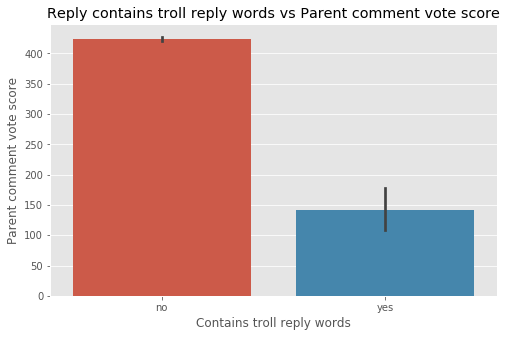

In [21]:
troll_reply_test(reply_df, 
                 'replyto_score', 
                 alpha=0.05, 
                 label='Parent comment vote score' )

### Feature test 2: number of replies


In a previous analysis, I found that number of replies was related to comments score in a slightly complicated way: comments that were highly donvoted tended to have more replies, but comments that were highly upvoted  also had more replies. In this case, I have no particular directional prediction, except that there is likely to be some significant effect of troll-replies vs number of replies.




Dependent variable: replyto_num_replies
Mean: NO = 29.313, YES = 16.334
unpaired t-test results: t = 7.654, pval = 0.000000 significant


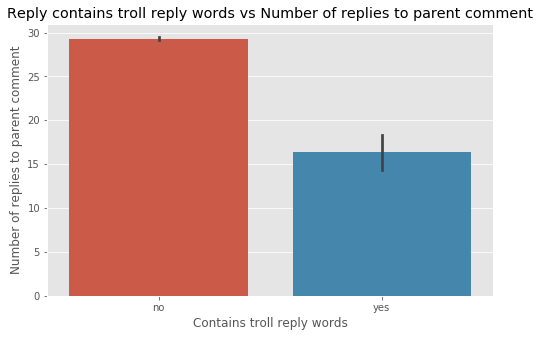

In [22]:
troll_reply_test(reply_df, 
                 'replyto_num_replies', 
                 alpha=0.05, 
                 label='Number of replies to parent comment' )


### Feature test 3: user coment karma

User comment karma gives a sense of how well recieved in general the commenter is in the Reddit community. Someone with low karma may be either disliked or using a new account (possibly after being banned or tagged as a troll). Therefore, I predict that comments replied to with "troll"will have lower karma.  



Dependent variable: replyto_com_karma
Mean: NO = 78336.982, YES = 59747.976
unpaired t-test results: t = 3.315, pval = 0.000916 significant


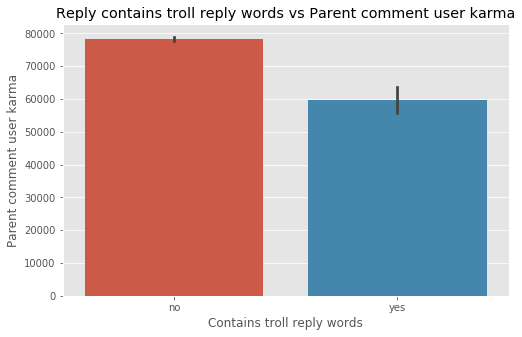

In [23]:
troll_reply_test(reply_df, 
                 'replyto_com_karma', 
                 alpha=0.05, 
                 label='Parent comment user karma' )

### Feature test 4: PCA score

PCA score is a combination of two features: vote score, and number of replies. These are moderately correlated, so if vote score is associated with replies with "troll" in the text (i.e., troll callouts), then PCA score should be similarly associated (lower when replies contain the word "troll").



Dependent variable: replyto_pca_score
Mean: NO = 1.145, YES = 0.253
unpaired t-test results: t = 25.962, pval = 0.000000 significant


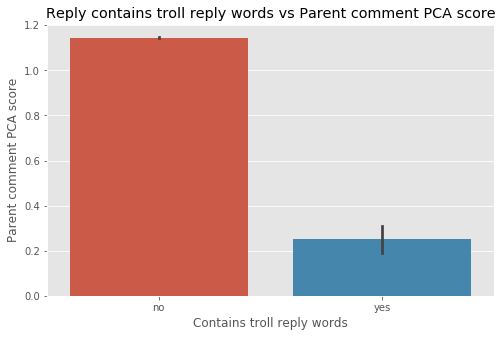

In [24]:
troll_reply_test(reply_df, 
                 'replyto_pca_score', 
                 alpha=0.05, 
                 label='Parent comment PCA score' )

## Results

All of the features I tested here were significantly different when testing presence of "troll" in reply comments. 

**Test 1: vote score:** As predicted, troll words in replies were associated with lower vote score. 

**Test 2: number of replies:** Number of replies was also negatively associated with the presence of "troll" in replies. This is interesting, and not entirely expected based on comparing vote score vs number of replies. Apparently, people tend to avoid replying to troll / toxic comments.

**Test 3: user coment karma:** As predicted, "troll replies" were associated with users with lower comment karma. The effect size here is not very large, however.

**Test 4: PCA score:** Given that a lower vote score was strongly associated with "troll replies", it isn't too surprising that PCA score similarly associated. This feature had that largest effect size. 


## Additional analysis: words associated with "troll"

Since I have the reply text loaded up so nicely, now would be a good time to take a look at what other words are assiciated with the word "troll" in this comment corpus. Knowing these words could help me develop a more accurate "troll reply" labelling method. 

### Methods

- Prepare the text a bit - lowercase, strip non-alphanumeric characters, stem.
- Train a word2vec model using prepared reply text containing "troll".
- Query the model for the nearest words to "troll"

In [25]:
# prepare the text

import re
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords as sw

# function to prepare text for NLP analysis
def process_comment_text(comments, 
                         stemmer=None, 
                         regexstr=None, lowercase=True,
                         removestop=False):
    
    if type(stemmer) == str:
        if stemmer.lower() == 'porter':
            stemmer = PorterStemmer()
        elif stemmer.lower() == 'snowball':
            stemmer = SnowballStemmer(language='english')
        else:
            stemmer = None
            
    processed = comments
    
    # make text lowercase
    if lowercase == True:
#         print('make text lowercase')
        processed = processed.str.lower()
        
    # remove stop words
    # NOTE: stop words w/ capitals not removed!
    if removestop == True:
#         print('remove stop words')
        stopwords = sw.words("english")
        processed = processed.map(lambda text: ' '.join([word for word in text.split() if word not in stopwords]))
        
    # apply regex expression
    if regexstr is not None:
#         print('apply regex expression')
        regex = re.compile(regexstr) 
        processed = processed.str.replace(regex,' ')
        
    # stemming
    # NOTE: stemming makes all lowercase
    if stemmer is not None:
#         print('stemming')
        processed = processed.map(lambda x: ' '.join([stemmer.stem(y) for y in x.split(' ')]))
        
#     print('done')
        
    return processed

processkwargs = {
    'stemmer':'snowball',
    'regexstr':'[^a-zA-Z0-9\s]',
    'lowercase':True,
    'removestop':False
                }
troll_replies = process_comment_text( 
    reply_df['text'][reply_df['istrollreply']=='yes'], **processkwargs)

# print('Number of troll replies analyzed:',len(troll_replies))

In [26]:
# tokenize comments and train the word2vec model

# hide warnings
warnings.filterwarnings(action='ignore', category=UserWarning, 
                        module='gensim')

from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
from gensim.utils import simple_preprocess
from time import time

t0 = time()

# convert text to tokenized format
documents = [simple_preprocess(doc) for i, doc in enumerate(troll_replies)]

# build vocabulary and train model
model_w2v = Word2Vec(
    documents,
    size=150,
    window=10,
    min_count=2,
    workers=10,
    iter=10)

print("model training done in %0.3fs" % (time() - t0))


model training done in 3.324s


In [27]:
# show the nearest words to 'troll'

similarwords = model_w2v.wv.most_similar('troll')

print('Similar words to "troll", most similar first:')
for word,score in similarwords:
    print(' ',word)


Similar words to "troll", most similar first:
  downvot
  batshit
  pretend
  dummi
  cuck
  dude
  shit
  yeah
  upset
  asshol


## Conclusions

When a comment is replied to with a "troll callout" (a comment containing the word "troll"), it is more likely to have a lower vote score, have fewer replies, the user will have lower comment karma, and the PCA score will be lower. All of these are indications that comment features can be used as a proxy to label comments as likely toxic. In fact, the PCA score I created earlier has the largest effect size of the features tested, which means that PCA score is indeed a reasonable feature to use as a label for training a model to predict comment toxicity.

The word analysis further verifies that the word "troll" is associated with adversarial replies: the associated words are typical of what you might expect from a callout of a troll / toxic comment.